# Rotten Tomatoes Web Scraper for Top 100 Movies Between 2000 and 2021

This is currently a work-in-progress. I want to use this as practice for data collection for data science skills. I wanted a dataset to perform analyses on, but I felt I needed to create my own extensive dataset.

Unfortunately (or, should I say, good for the person who already did it) there already exists a Rotten Tomatoes dataset just like the one I am trying to make here. I did not come across this work until I was already through the beginning stages of this project, but I shall link that dataset here for anyone interested. This guy also has other movie datasets on Kaggle and seems like an interesting guy. Check him out: https://www.kaggle.com/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset

Anyway, it was also good to know that the creator of the above dataset also had to wait a day or so for all the data to be collected.

Below you will find a test I did on the movie Interstellar, my favorite movie which did not make the top 100 movie list for 2014 somehow....

Below that I have defined some functions to aid in the collection of review data for the top 100 movies for each year between 2000 and 2021. Collecting all this data takes a *long* time. You will see somewhere in the comments me complaining about my poor internet, and how I had to settle for only scraping data for the year 2021 as a result.

In [94]:
from bs4 import BeautifulSoup
from selenium import webdriver #for dynamically loaded page elements that requests won't read in
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
service = Service('C:/Users/cbarg/Downloads/chromedriver_win32/chromedriver.exe') #if anyone ever dares use this you need to replace this with the path to your own chromedriver or what have you
import time
import re
import gensim
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import numpy as np
from keras.callbacks import ModelCheckpoint
from keras import layers
from keras import regularizers
from keras import backend as K

In [2]:
driver = webdriver.Chrome(service=service)
driver.get('https://www.rottentomatoes.com/m/interstellar_2014/reviews')
html = driver.page_source
soup = BeautifulSoup(html) #grab the information on the initial page

#grab all the reviews on current page
review_rows = soup.find_all('div', class_ = 'row review_table_row')

while True:
    try:
        element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, '//*[@id="content"]/div/div/div/nav[1]/button[2]'))
        )
        element.click()
        time.sleep(1)
        html = driver.page_source
        soup = BeautifulSoup(html)
        review_rows.extend(soup.find_all('div', class_ = 'row review_table_row'))
    except:
        print('Task exited successfully.')
        driver.quit()
        break
        
critic = []
date = []
reviews = []
score = []
is_fresh = []
is_rotten = []
is_top_critic = []

for review in review_rows:
    critic.append(review.find('a', class_ = 'unstyled bold articleLink').text) #critic's name
    date.append(review.find('div', class_ = 'review-date subtle small').text.strip()) #date of review
    reviews.append(review.find('div', class_ = 'the_review').text.strip()) #comments by reviewer
    
    #the way the review score works is pretty messed up. Even with this cleaning all the scales are different
    foo = review.find('div', class_ = 'small subtle review-link').text.strip().split('|')
    if len(foo) >= 2:
        score.append(foo[1].split(' ')[3])
    else:
        score.append(None)
        
    #check if a critic rated the movie as fresh or not
    if review.find('div', class_ = 'review_icon icon small fresh'):
        is_fresh.append(1)
    else:
        is_fresh.append(0)
        
    #check to see if a critic rated the movie as rotten or not
    if review.find('div', class_ = 'review_icon icon small rotten'):
        is_rotten.append(1)
    else:
        is_rotten.append(0)
    
    #check to see if the review was posted by a top critic
    if review.find('rt-icon-top-critic', class_ = 'small'): 
        is_top_critic.append(1)
    else:
        is_top_critic.append(0)

Task exited successfully.


In [3]:
import pandas as pd
import numpy as np
  
df_dict = {'critic':critic, 'date':date, 'reviews':reviews, 'score':score, 'is_fresh':is_fresh, 'is_rotten':is_rotten, 'is_top_critic':is_top_critic}
columns = ['critic', 'date', 'review', 'score', 
            'is_fresh', 'is_rotten', 'is_top_critic']
  
# Calling DataFrame constructor on list
df = pd.DataFrame(df_dict)
df.head(15)

,critic,date,reviews,score,is_fresh,is_rotten,is_top_critic
0,Therese Lacson,"Oct 9, 2021","The inherent message of the film brings hope, ...",3/5,1,0,0
1,Kip Mooney,"Aug 10, 2021",The film is indeed a sight to behold -- and on...,B,1,0,0
2,Richard Crouse,"Feb 2, 2021",Nolan reaches for the stars with beautifully c...,3/5,1,0,0
3,Mike Massie,"Dec 4, 2020",Audiences are sure to lose their suspensions o...,5/10,0,1,0
4,David Nusair,"Sep 20, 2020",...an often insanely ambitious science fiction...,4/4,1,0,0
5,Richard Propes,"Sep 12, 2020","Scientists will debate, theologians will conte...",3.5/4.0,1,0,0
6,Siddhant Adlakha,"Sep 3, 2020",A big-budget reprise of ideas Nolan has been e...,None,1,0,0
7,Stephen A. Russell,"Aug 26, 2020",None of these characters feel fully-fledged......,2.5/5,0,1,0
8,Kelechi Ehenulo,"Jul 16, 2020",Interstellar is not Christopher Nolan's best f...,4/5,1,0,0
9,Brent McKnight,"Jul 7, 2020",As spectacular as it is flawed.,B,1,0,0


In [4]:
#returns a dictionary of years and the links to the associated top 100 movies of that year on rotten tomatoes
def get_years_url_dict(tomatoes='https://www.rottentomatoes.com/top/'):
    driver = webdriver.Chrome(service=service)
    driver.get(tomatoes)
    time.sleep(1)
    html = driver.page_source
    soup = BeautifulSoup(html)
    driver.close()
    
    table = soup.find('div', style='position: absolute; left: 366px; top: 733px;')
    entries = table.find_all('td', class_='rank_col')
    years = [year.text.strip() for year in entries]
    links = [link.find('a', href=True)['href'] for link in entries]
    links = [tomatoes[:-5] + link for link in links]
    dictionary = {years[i]:links[i] for i in range(len(years))}
    return dictionary

url_by_years = get_years_url_dict()

In [5]:
#returns a dictionary of all the movie titles and the link to their main rotten tomatoes page
#for all the movies that are in the top 100 lists for years 2000-2021
def get_movie_urls(dictionary):
    driver = webdriver.Chrome(service=service)
    top_links = {}
    for key in dictionary.keys():
        html = str(dictionary[key])
        driver.get(html)
        time.sleep(1)
        soup = BeautifulSoup(driver.page_source)
        
        top_movies_section = soup.find('section', id='top_movies_main')
        table = top_movies_section.find('tbody')
        rows = table.find_all('tr')
        links = [row.find('a', href=True)['href'] for row in rows]
        links = ['https://www.rottentomatoes.com' + link for link in links]
        titles = [row.find('a', href=True).text.strip() for row in rows]
        new_dictionary = {titles[i]:links[i] for i in range(len(titles))}
        top_links.update(new_dictionary)
    driver.close()
    return top_links

all_movie_links = get_movie_urls(url_by_years)
print(list(all_movie_links)[:50]) #print the first 50 movies in the dictionary. There are 2100 of them so I'm not printing them all

['Nomadland (2021)', 'Judas and the Black Messiah (2021)', 'The Father (2021)', 'In the Heights (2021)', 'Summer of Soul (...Or, When the Revolution Could Not Be Televised) (2021)', 'Pig (2021)', 'CODA (2021)', 'Raya and the Last Dragon (2021)', 'A Quiet Place Part II (2021)', 'The Mitchells vs. The Machines (2021)', 'Shang-Chi and the Legend of the Ten Rings (2021)', 'The Suicide Squad (2021)', 'MLK/FBI (2021)', 'Shiva Baby (2021)', 'Luca (2021)', 'Quo Vadis, Aida? (2021)', 'Slalom (2021)', 'Becoming Cousteau (Cousteau) (2021)', 'Beyond the Infinite Two Minutes (2021)', 'Paper Spiders (2021)', 'Woodlands Dark and Days Bewitched: A History of Folk Horror (2021)', 'Sabaya (2021)', 'The Worst Person In The World (Verdens Verste Menneske) (2021)', 'Luzzu (2021)', 'Two of Us (Deux) (2021)', 'The Velvet Underground (2021)', 'The Sparks Brothers (2021)', 'Riders of Justice (2021)', 'Mass (2021)', "I'm Your Man (2021)", 'I Carry You with Me (2021)', 'The Paper Tigers (2021)', 'Identifying Fea

In [8]:
def obtain_url_data(dictionary):
    titles = []
    tomatometer_scores_avg = []
    audience_scores_avg = []
    critic = []
    date = []
    reviews = []
    score = []
    is_fresh = []
    is_rotten = []
    is_top_critic = []
    year_gen_len = []
    directors = []
    grosses = []
    keys = dictionary.keys()
    
    #this for loop goes through all the movies from 2001 to extract the reviews and other data from those movies
    #this is easily converted to a function that can grab reviews from the movies for any year from 2000-2021, but
    #my internet is sooooo slow so I would try to go through all 2100 movies at once and my internet would crap out
    #once I got to around 2004 or so and the process wouldn't finish. So just doing one year was easier. if you had good internet
    #though you could use this function to collect reviews from the all top 100 movies on rotten tomatoes between 2000 and 2021
    #for key in [key for key in keys if '(2021)' in key]:
    
    #you can ignore the comments above about the year 2001. I changed it back to the original function for the test dictionary below
    for key in keys:
        driver = webdriver.Chrome(service=service) #define the driver
        
        #going to the main movie page to extract information
        driver.get(dictionary[key])
        time.sleep(1)
        html = driver.page_source
        soup = BeautifulSoup(html)
        
        try:
            #get tomatometer score
            tomatometer_score = soup.find('score-board', tomatometerscore=True)['tomatometerscore']
            #get audience score
            audience_score = soup.find('score-board', audiencescore=True)['audiencescore']
            #get year, genre, and length of movie
            year_genre_length = soup.find('p', class_='scoreboard__info').text.strip()
            #get director's name
            director = soup.find('a', attrs={'data-qa':'movie-info-director'}).text.strip()
            #get film gross revenue
            box_office_tags = soup.find_all('div', class_ = 'meta-value')
            gross = '0'
            for tag in box_office_tags:
                if '$' in tag.text.strip():
                    gross = tag.text.strip()
                    #print(tag.text.strip())
                    break
            print(gross) #print the movie's gross to make sure it was obtained


            #going to the reviews page to extract information
            driver.get(dictionary[key] + '/reviews')
            html = driver.page_source
            soup = BeautifulSoup(html) #grab the information on the initial page

            #grab all the reviews on current page
            review_rows = soup.find_all('div', class_ = 'row review_table_row')
        except:
            #driver.close()
            print('Unsuccessful collection for {}.'.format(key))
            continue

        #now we want to start nagivagting through all the reviews
        #this while loop goes through every review and extracts its information to be stored in a list
        #if an error is encountered then it stops collecting reviews and closes the driver

        while True:
            try:
                element = WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.XPATH, '//*[@id="content"]/div/div/div/nav[1]/button[2]'))
                )
                element.click()
                time.sleep(0.5)
                html = driver.page_source
                soup = BeautifulSoup(html)
                review_rows.extend(soup.find_all('div', class_ = 'row review_table_row'))
            except:
                print('Successfully collected reviews for {}.'.format(key))
                driver.quit()
                break
        
        #goes through the list of reviews and splits each entry up into the individual information chunks
        for review in review_rows:

            try:
                critic_name = review.find('a', class_ = 'unstyled bold articleLink').text #crtic's name

                review_date = review.find('div', class_ = 'review-date subtle small').text.strip() #date of review

                critic_comments = review.find('div', class_ = 'the_review').text.strip() #comments by the reviewer

                #the way the review score works is pretty messed up. Even with this cleaning all the scales are different
                foo = review.find('div', class_ = 'small subtle review-link').text.strip().split('|')
                if len(foo) >= 2:
                    score.append(foo[1].split(' ')[3])
                else:
                    score.append(None)

                #check if a critic rated the movie as fresh or not
                if review.find('div', class_ = 'review_icon icon small fresh'):
                    is_fresh.append(1)
                else:
                    is_fresh.append(0)

                #check to see if a critic rated the movie as rotten or not
                if review.find('div', class_ = 'review_icon icon small rotten'):
                    is_rotten.append(1)
                else:
                    is_rotten.append(0)

                #check to see if the review was posted by a top critic
                if review.find('rt-icon-top-critic', class_ = 'small'): 
                    is_top_critic.append(1)
                else:
                    is_top_critic.append(0)

                    
                #all of the data is added to the list at the same time at the end of the loop
                #this is because if an error has occurred during an earlier part of the loop
                #we dont want to quit mid-loop and have one of the lists be longer than another
                #that would cause us to receive an error when creating the dataframe
                titles.append(key)
                tomatometer_scores_avg.append(tomatometer_score)
                audience_scores_avg.append(audience_score)
                year_gen_len.append(year_genre_length)
                directors.append(director)
                critic.append(critic_name)
                date.append(review_date)
                reviews.append(critic_comments)
                grosses.append(gross)
            except:
                driver.close()
                break

                
    df_dict = {'title':titles, 'director':directors, 'gross (usd)':grosses, 'tomatometer_scores_avg':tomatometer_scores_avg, 'audience_scores_avg':audience_scores_avg, 'year_genre_length':year_gen_len, 'critic':critic, 'date_of_review':date, 'reviews':reviews, 'score':score, 'is_fresh':is_fresh, 'is_rotten':is_rotten, 'is_top_critic':is_top_critic}
    #print(df_dict)
    # Calling DataFrame constructor on list
    df = pd.DataFrame(df_dict)
    return df

In [9]:
#all_movie_links.update({'Interstellar (2014)':'https://www.rottentomatoes.com/m/interstellar_2014'})

#i should explain this test dictionary. I included Donnie Darko's Director's Cut because there is simply no info
#on it on rotten tomatoes. It shows up in the top movie's links for 2004, but it's page might as well not exist at all
#it's placed in here to see how my function handles it.
#Interstellar is my favorite movie ever, so that's why that's here
#A Quiert Place Part II was just a more recent, successful movie
test_dictionary = {"Donnie Darko: The Director's Cut (2004)": 'https://www.rottentomatoes.com/m/donnie_darko_the_directors_cut',
                  'Interstellar (2014)':'https://www.rottentomatoes.com/m/interstellar_2014',
                  'A Quiet Place Part II (2021)': 'https://www.rottentomatoes.com/m/a_quiet_place_part_ii'}
df = obtain_url_data(test_dictionary)

Unsuccessful collection for Donnie Darko: The Director's Cut (2004).
$188.0M
Successfully collected reviews for Interstellar (2014).
$160.2M
Successfully collected reviews for A Quiet Place Part II (2021).


In [10]:
df.to_csv('rotten_tomatoes_review_data_test_dict.csv', sep='\t', index=False)

In [11]:
df.tail()

,title,director,gross (usd),tomatometer_scores_avg,audience_scores_avg,year_genre_length,critic,date_of_review,reviews,score,is_fresh,is_rotten,is_top_critic
830,A Quiet Place Part II (2021),John Krasinski,$160.2M,91,92,"2021, Mystery & thriller/Horror, 1h 37m",Jacob Oller,"May 18, 2021",A Quiet Place Part II's technical merits mostl...,7.0/10,1,0,0
831,A Quiet Place Part II (2021),John Krasinski,$160.2M,91,92,"2021, Mystery & thriller/Horror, 1h 37m",David Rooney,"May 18, 2021",The intimacy of the storytelling tugs relentle...,None,1,0,1
832,A Quiet Place Part II (2021),John Krasinski,$160.2M,91,92,"2021, Mystery & thriller/Horror, 1h 37m",Peter Bradshaw,"May 18, 2021","What a pleasure to see a big, brash picture li...",4/5,1,0,1
833,A Quiet Place Part II (2021),John Krasinski,$160.2M,91,92,"2021, Mystery & thriller/Horror, 1h 37m",Joey Magidson,"May 18, 2021",A Quiet Place Part II manages to take a really...,3.5/4,1,0,0
834,A Quiet Place Part II (2021),John Krasinski,$160.2M,91,92,"2021, Mystery & thriller/Horror, 1h 37m",Kate Erbland,"May 18, 2021",As his chops as an action and horror director ...,B+,1,0,1


In [12]:
df.head()

,title,director,gross (usd),tomatometer_scores_avg,audience_scores_avg,year_genre_length,critic,date_of_review,reviews,score,is_fresh,is_rotten,is_top_critic
0,Interstellar (2014),Christopher Nolan,$188.0M,72,86,"2014, Sci-fi/Adventure, 2h 45m",Therese Lacson,"Oct 9, 2021","The inherent message of the film brings hope, ...",3/5,1,0,0
1,Interstellar (2014),Christopher Nolan,$188.0M,72,86,"2014, Sci-fi/Adventure, 2h 45m",Kip Mooney,"Aug 10, 2021",The film is indeed a sight to behold -- and on...,B,1,0,0
2,Interstellar (2014),Christopher Nolan,$188.0M,72,86,"2014, Sci-fi/Adventure, 2h 45m",Richard Crouse,"Feb 2, 2021",Nolan reaches for the stars with beautifully c...,3/5,1,0,0
3,Interstellar (2014),Christopher Nolan,$188.0M,72,86,"2014, Sci-fi/Adventure, 2h 45m",Mike Massie,"Dec 4, 2020",Audiences are sure to lose their suspensions o...,5/10,0,1,0
4,Interstellar (2014),Christopher Nolan,$188.0M,72,86,"2014, Sci-fi/Adventure, 2h 45m",David Nusair,"Sep 20, 2020",...an often insanely ambitious science fiction...,4/4,1,0,0


In [13]:
df.shape

(835, 13)

In [14]:
len(df['title'].unique())

2

In [15]:
len(df['director'].unique())

2

# Data Analysis

In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('rotten_tomatoes_review_data.csv', delimiter = '\t')
df.head()

,title,director,gross (usd),tomatometer_scores_avg,audience_scores_avg,year_genre_length,critic,date_of_review,reviews,score,is_fresh,is_rotten,is_top_critic
0,Nomadland (2021),Chloé Zhao,0,93,82.0,"2020, Drama, 1h 48m",Victor Pineyro,"Oct 22, 2021","We are terrified by the idea that, as Fern, we...",9/10,1,0,0
1,Nomadland (2021),Chloé Zhao,0,93,82.0,"2020, Drama, 1h 48m",Fernanda Solórzano,"Sep 28, 2021",Beautiful cinematography in an alienating film...,NaN,0,1,0
2,Nomadland (2021),Chloé Zhao,0,93,82.0,"2020, Drama, 1h 48m",Witney Seibold,"Sep 13, 2021",Featuring one of McDormand's best performances...,NaN,1,0,0
3,Nomadland (2021),Chloé Zhao,0,93,82.0,"2020, Drama, 1h 48m",Robin Holabird,"Jul 16, 2021",This warmth and genuine appreciation of people...,NaN,1,0,0
4,Nomadland (2021),Chloé Zhao,0,93,82.0,"2020, Drama, 1h 48m",David Katz,"Jul 13, 2021","It ultimately reverts to homilies, offering a ...",B-,0,1,0


The goal (at least for now) is a sentiment analysis on this dataset. So all I really want to look at for now are the columns 'reviews' and the 'is_rotten' columns. The column 'is_fresh' could be switched out for 'is_rotten' since both contain essentially the same information.

In [29]:
df_analysis = df[['reviews', 'is_rotten']]

In [30]:
#counts of good reviews and bad reviews
df_analysis['is_rotten'].value_counts()

0    15024
1     1373
Name: is_rotten, dtype: int64

Most of the reviews are positive. This is expected since I only scraped data from the top 100 movies for the year 2021 in this particular dataset. Now we can start to perform some sentiment analysis. Let's import the necessary libraries.

In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer

We should transform our text data into something that our machine learning model understands. Basically, we need to convert the text into an array of vector embeddings. Word embeddings are a beautiful way of representing the relationship between the words in the text.

To do this, we first give each of the unique words a unique number and then replace that word with the number assigned.

First, retrieve all the text data from the dataset.

In [32]:
review = df_analysis.reviews.values
sentiment_label = df_analysis.is_rotten.factorize()
sentiment_label

(array([0, 1, 0, ..., 1, 0, 0], dtype=int64),
 Int64Index([0, 1], dtype='int64'))

Notice how all the rotten reviews are labeled as '1' and the fresh reviews are labeled as '0'.

Now, before proceeding ahead in python sentiment analysis project let’s tokenize all the words in the text with the help of Tokenizer. In tokenization, we break down all the words/sentences of a text into small parts called tokens.

In [33]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(review)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(review)
print(tokenizer.word_index)

{'the': 1, 'a': 2, 'and': 3, 'of': 4, 'to': 5, 'is': 6, 'in': 7, 'that': 8, 'it': 9, 'with': 10, 'as': 11, 'but': 12, 'film': 13, 'this': 14, 'an': 15, 'for': 16, 'its': 17, "it's": 18, 'on': 19, 'be': 20, 'you': 21, 'movie': 22, 'from': 23, 'one': 24, 'by': 25, 'not': 26, 'at': 27, 'about': 28, 'all': 29, 'story': 30, 'more': 31, 'are': 32, 'has': 33, 'like': 34, 'his': 35, 'into': 36, 'what': 37, 'i': 38, 'than': 39, 'have': 40, 'so': 41, 'will': 42, 'if': 43, 'full': 44, 'just': 45, 'who': 46, 'time': 47, 'her': 48, 'most': 49, 'best': 50, 'much': 51, 'some': 52, 'up': 53, 'or': 54, 'can': 55, 'out': 56, 'even': 57, 'us': 58, 'life': 59, 'while': 60, 'well': 61, 'action': 62, 'how': 63, 'director': 64, 'we': 65, 'performances': 66, 'their': 67, 'way': 68, 'review': 69, 'also': 70, 'good': 71, 'was': 72, 'spanish': 73, 'horror': 74, 'performance': 75, 'black': 76, 'which': 77, 'world': 78, 'make': 79, 'makes': 80, 'love': 81, 'there': 82, 'no': 83, 'documentary': 84, 'never': 85, 'to

The fit_on_texts() method creates an association between the words and the assigned numbers. This association is stored in the form of a dictionary in the tokenizer.word_index attribute.

Now, replace the words with their assigned numbers using the text_to_sequence() method.

In [34]:
encoded_docs = tokenizer.texts_to_sequences(review)
print(review[0])
print(encoded_docs[0])

We are terrified by the idea that, as Fern, we might have an incredibly frail appearance of stability. What would we do if life doesn't turn out the way we wanted it to? Nomadland provided the freedom we wanted in 2020. [Full review in Spanish]
[65, 32, 25, 1, 817, 8, 11, 828, 65, 145, 40, 15, 818, 2911, 4, 37, 206, 65, 146, 43, 59, 101, 382, 56, 1, 68, 65, 1016, 9, 5, 244, 4327, 1, 1664, 65, 1016, 7, 1981, 44, 69, 7, 73]


Each of the sentences in the dataset is not of equal length. Use padding to pad the sentences to have equal length.

In [51]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_sequence = pad_sequences(encoded_docs, maxlen=50)
print(padded_sequence[0])

[   0    0    0    0    0    0    0    0   65   32   25    1  817    8
   11  828   65  145   40   15  818 2911    4   37  206   65  146   43
   59  101  382   56    1   68   65 1016    9    5  244 4327    1 1664
   65 1016    7 1981   44   69    7   73]


# Build the text classifier

For sentiment analysis project, we use LSTM layers in the machine learning model. The architecture of our model consists of an embedding layer, an LSTM layer, and a Dense layer at the end. To avoid overfitting, we introduced the Dropout mechanism in-between the LSTM layers.

LSTM stands for Long Short Term Memory Networks. It is a variant of Recurrent Neural Networks. Recurrent Neural Networks are usually used with sequential data such as text and audio. Usually, while computing an embedding matrix, the meaning of every word and its calculations (which are called hidden states) are stored. If the reference of a word, let’s say a word is used after 100 words in a text, then all these calculations RNNs cannot store in its memory. That’s why RNNs are not capable of learning these long-term dependencies.

LSTMs on the other hand work well with such text. LSTM networks work well with time-series data.

Dropout is one of the regularization techniques. It is used to avoid overfitting. In the dropout mechanism, we drop some neurons randomly. The layer takes an argument, a number between 0 and 1 that represents the probability to drop the neurons. This creates a robust model avoiding overfitting.

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=50))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model.build()
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 32)            562304    
                                                                 
 spatial_dropout1d_9 (Spatia  (None, 50, 32)           0         
 lDropout1D)                                                     
                                                                 
 lstm_9 (LSTM)               (None, 50)                16600     
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 578,955
Trainable params: 578,955
Non-trainable params: 0
_______________________________________________

# Train the model

Train the sentiment analysis model for 5 epochs on the whole dataset with a batch size of 32 and a validation split of 20%.

In [56]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=20, batch_size=32)

Epoch 1/20
410/410 [==============================] - 13s 30ms/step - loss: 0.0584 - accuracy: 0.9806 - val_loss: 0.5126 - val_accuracy: 0.8933
Epoch 2/20
410/410 [==============================] - 11s 26ms/step - loss: 0.0476 - accuracy: 0.9833 - val_loss: 0.5673 - val_accuracy: 0.8899
Epoch 3/20
410/410 [==============================] - 11s 26ms/step - loss: 0.0389 - accuracy: 0.9867 - val_loss: 0.5413 - val_accuracy: 0.8872
Epoch 4/20
410/410 [==============================] - 10s 25ms/step - loss: 0.0334 - accuracy: 0.9886 - val_loss: 0.6124 - val_accuracy: 0.8893
Epoch 5/20
410/410 [==============================] - 10s 25ms/step - loss: 0.0301 - accuracy: 0.9900 - val_loss: 0.5976 - val_accuracy: 0.8933
Epoch 6/20
410/410 [==============================] - 10s 25ms/step - loss: 0.0224 - accuracy: 0.9921 - val_loss: 0.7581 - val_accuracy: 0.8927
Epoch 7/20
410/410 [==============================] - 11s 26ms/step - loss: 0.0202 - accuracy: 0.9929 - val_loss: 0.6670 - val_accuracy:

The python sentiment analysis model obtained 97.4% accuracy on the training set and 89.3% accuracy on the test set.

Let's plot these metrics using matplotlib.

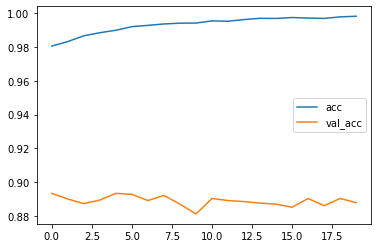

<Figure size 432x288 with 0 Axes>

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

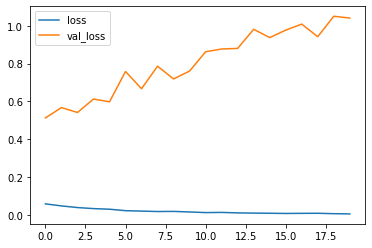

<Figure size 432x288 with 0 Axes>

In [58]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plt.jpg")

# Execute the Model

Define a function that takes a text as input and outputs its prediction label.

In [60]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=50)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])

    
test_sentence1 = "The film's breadth of opinions - of which there are too many to recount in a single article - indicates that there is no 'right' choice, and impressively captures a debate that may not rage forever."
predict_sentiment(test_sentence1)
test_sentence2 = "The documentary would have been that much better with a more explicit focus on why the average filmgoer should care."
predict_sentiment(test_sentence2)

Predicted label:  0
Predicted label:  1


# Cleaning the data more before training a model

In [64]:
review_words = df_analysis['reviews']
review_words

0        We are terrified by the idea that, as Fern, we...
1        Beautiful cinematography in an alienating film...
2        Featuring one of McDormand's best performances...
3        This warmth and genuine appreciation of people...
4        It ultimately reverts to homilies, offering a ...
                               ...                        
16392    Far closer in spirit to the lighter works of M...
16393    The film's whisper-thin premise and sitcom-lik...
16394    Deploys some talented performers on both sides...
16395    It's a strong directorial debut from Bird...th...
16396    An unexpectedly gentle and pensive portrait of...
Name: reviews, Length: 16397, dtype: object

In [73]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
    
    #remove bracket characters
    data = re.sub('\[', '', data)
    data = re.sub('\]', '', data)
        
    return data

In [74]:
temp = []
#Splitting pd.Series to list
data_to_list = df_analysis['reviews'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['We are terrified by the idea that, as Fern, we might have an incredibly frail appearance of stability. What would we do if life doesnt turn out the way we wanted it to? Nomadland provided the freedom we wanted in 2020. Full review in Spanish',
 'Beautiful cinematography in an alienating film doesnt have much value... Nomadland ends up idealizing an unideal situation. Full review in Spanish',
 'Featuring one of McDormands best performances - a role she occupies deeply - and emotionally dissecting the economic terrors of backwater America, Nomadland is one of the best of the year.',
 'This warmth and genuine appreciation of people and the many routes they take make Nomadland one of the best movies in Nevadas supply of road pictures.',
 'It ultimately reverts to homilies, offering a flinty, exciting character a bland third-act volte-face.']

In [77]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:5])

[['we', 'are', 'terrified', 'by', 'the', 'idea', 'that', 'as', 'fern', 'we', 'might', 'have', 'an', 'incredibly', 'frail', 'appearance', 'of', 'stability', 'what', 'would', 'we', 'do', 'if', 'life', 'doesnt', 'turn', 'out', 'the', 'way', 'we', 'wanted', 'it', 'to', 'nomadland', 'provided', 'the', 'freedom', 'we', 'wanted', 'in', 'full', 'review', 'in', 'spanish'], ['beautiful', 'cinematography', 'in', 'an', 'alienating', 'film', 'doesnt', 'have', 'much', 'value', 'nomadland', 'ends', 'up', 'idealizing', 'an', 'unideal', 'situation', 'full', 'review', 'in', 'spanish'], ['featuring', 'one', 'of', 'mcdormands', 'best', 'performances', 'role', 'she', 'occupies', 'deeply', 'and', 'emotionally', 'dissecting', 'the', 'economic', 'terrors', 'of', 'backwater', 'america', 'nomadland', 'is', 'one', 'of', 'the', 'best', 'of', 'the', 'year'], ['this', 'warmth', 'and', 'genuine', 'appreciation', 'of', 'people', 'and', 'the', 'many', 'routes', 'they', 'take', 'make', 'nomadland', 'one', 'of', 'the', 

In [81]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

review = []
for i in range(len(data_words)):
    review.append(detokenize(data_words[i]))
print(review[:5])

['we are terrified by the idea that as fern we might have an incredibly frail appearance of stability what would we do if life doesnt turn out the way we wanted it to nomadland provided the freedom we wanted in full review in spanish', 'beautiful cinematography in an alienating film doesnt have much value nomadland ends up idealizing an unideal situation full review in spanish', 'featuring one of mcdormands best performances role she occupies deeply and emotionally dissecting the economic terrors of backwater america nomadland is one of the best of the year', 'this warmth and genuine appreciation of people and the many routes they take make nomadland one of the best movies in nevadas supply of road pictures', 'it ultimately reverts to homilies offering flinty exciting character bland third act volte face']


In [85]:
data = np.array(review)

In [86]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(review)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(review)

In [87]:
encoded_docs = tokenizer.texts_to_sequences(review)
print(review[0])
print(encoded_docs[0])

we are terrified by the idea that as fern we might have an incredibly frail appearance of stability what would we do if life doesnt turn out the way we wanted it to nomadland provided the freedom we wanted in full review in spanish
[63, 30, 23, 1, 819, 8, 11, 828, 63, 143, 37, 14, 820, 2884, 3, 35, 207, 63, 144, 40, 57, 98, 380, 53, 1, 66, 63, 1013, 9, 4, 229, 4272, 1, 1657, 63, 1013, 6, 41, 67, 6, 71]


In [88]:
padded_sequence = pad_sequences(encoded_docs, maxlen=50)
print(padded_sequence[0])

[   0    0    0    0    0    0    0    0    0   63   30   23    1  819
    8   11  828   63  143   37   14  820 2884    3   35  207   63  144
   40   57   98  380   53    1   66   63 1013    9    4  229 4272    1
 1657   63 1013    6   41   67    6   71]


In [89]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=50))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model.build()
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 50, 32)            541600    
                                                                 
 spatial_dropout1d_10 (Spati  (None, 50, 32)           0         
 alDropout1D)                                                    
                                                                 
 lstm_10 (LSTM)              (None, 50)                16600     
                                                                 
 dropout_10 (Dropout)        (None, 50)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 558,251
Trainable params: 558,251
Non-trainable params: 0
_______________________________________________

In [99]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
410/410 [==============================] - 13s 31ms/step - loss: 0.0093 - accuracy: 0.9974 - val_loss: 0.9498 - val_accuracy: 0.8933
Epoch 2/5
410/410 [==============================] - 12s 29ms/step - loss: 0.0053 - accuracy: 0.9982 - val_loss: 1.0655 - val_accuracy: 0.8915
Epoch 3/5
410/410 [==============================] - 12s 30ms/step - loss: 0.0064 - accuracy: 0.9977 - val_loss: 1.0301 - val_accuracy: 0.8915
Epoch 4/5
410/410 [==============================] - 11s 27ms/step - loss: 0.0081 - accuracy: 0.9973 - val_loss: 0.9488 - val_accuracy: 0.8927
Epoch 5/5
410/410 [==============================] - 11s 27ms/step - loss: 0.0060 - accuracy: 0.9979 - val_loss: 1.0493 - val_accuracy: 0.8936


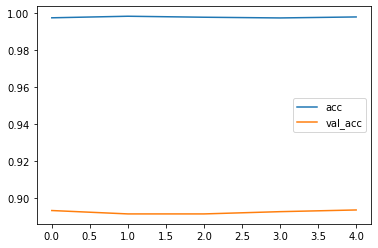

<Figure size 432x288 with 0 Axes>

In [100]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

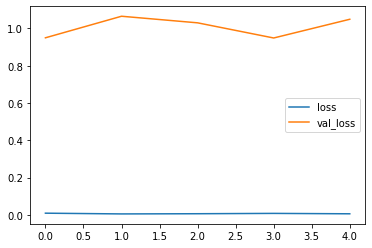

<Figure size 432x288 with 0 Axes>

In [101]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plt.jpg")

In [102]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=50)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])

    
test_sentence1 = "The film's breadth of opinions - of which there are too many to recount in a single article - indicates that there is no 'right' choice, and impressively captures a debate that may not rage forever."
predict_sentiment(test_sentence1)
test_sentence2 = "The documentary would have been that much better with a more explicit focus on why the average filmgoer should care."
predict_sentiment(test_sentence2)

Predicted label:  0
Predicted label:  1
